# Scoring notebook

This is the scoring notebook for the data driven competition at CMF 2022. You can change cells with `### YOUR CODE HERE` line, all other cells are read-only. However, you can add new cells to organize your code in a convenient way.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

Let us load the dataset. Columns in the test (public as well as private) dataset are equivalent to the train dataset.

In [2]:
dataset = pd.read_csv('dataset.zip', index_col=0, header=[0, 1])
dataset.rename(
    columns={
        'Unnamed: 209_level_1': 'count',
        'Unnamed: 210_level_1': 'price',
    },
    level = 1,
    inplace = True
)
dataset.head()

timestamp_second bid_price_0                                        \
  Unnamed: 0_level_1     nunique       mean   median       std     min   
0                  0           7  44.183379  44.1865  0.007340  44.171   
1                  1           1  44.190000  44.1900  0.000000  44.190   
2                  2           3  44.187467  44.1860  0.001767  44.186   
3                  3           3  44.181038  44.1860  0.006993  44.173   
4                  4           2  44.213095  44.2190  0.012474  44.188   

                          bid_quantity_0  ... sell_trade_quantity              \
      max   first    last        nunique  ...                 sum mean median   
0  44.190  44.171  44.190              5  ...                 0.0  NaN    NaN   
1  44.190  44.190  44.190              1  ...                 0.0  NaN    NaN   
2  44.190  44.190  44.186              3  ...                 0.0  NaN    NaN   
3  44.188  44.186  44.188              2  ...                 0.0  NaN    NaN   
4  44.219  44.188  44.219              2  ...                 0.0  NaN    NaN   

                                        count                    y  
  std min max first last Unnamed: 207_level_1 Unnamed: 208_level_1  
0 NaN NaN NaN   NaN  NaN                   66            -0.065894  
1 NaN NaN NaN   NaN  NaN                   13            -0.066870  
2 NaN NaN NaN   NaN  NaN                   15            -0.064833  
3 NaN NaN NaN   NaN  NaN                   52            -0.040764  
4 NaN NaN NaN   NaN  NaN                   21            -0.063813  

[5 rows x 209 columns]

In [4]:
class Dataloader():
    def __init__(
        self, 
        dataframe: pd.DataFrame, 
        window_size: int, 
        step_size: int,
        horizon: int,
        first_pred: int
    ):
        self.df = dataframe
        self.window_size = window_size
        self.step_size = step_size
        self.horizon = horizon
        self.first_pred = first_pred
        assert self.first_pred > self.window_size
        feat_idx = []
        target_idx = []
        for i in range(self.first_pred, self.df.shape[0], self.step_size):
            feat_idx.append(range(i-self.horizon-self.window_size+1, i-self.horizon+1))
            target_idx.append(i)
        self.feat_idx = feat_idx
        self.target_idx = target_idx
    
    def __len__(self):
        return len(self.feat_idx)
    
    def __iter__(self):
        self.iter = 0
        return self

    def __next__(self):
        if self.iter < len(self.feat_idx):
            feat = self.df.iloc[self.feat_idx[self.iter]]
            target = self.df.iloc[self.target_idx[self.iter], -1]
            self.iter += 1
            return feat, target
        else:
            raise StopIteration

Column **price** represents the price at moment **t**. The task is to predict **price** values at moment **t+60**.

The forecasting problem is defined as follows. Consider the multivariate time series of features (exogenous variables) $X_0, X_1, \dots $ where $X_i \in \mathbb{R}^d$. Consider the univariate time series of targets (endogenous variables) $y_0, y_1, ...$ where $y_i \in \mathbb{R}$. The task is to predict the $y_{T+h}$ where $T \in \{1000, 1001, \dots\}$ is the last available time stamp and $h = 60$ is the forecasting horizon by the given _sliding window_ over pairs $(X, y)_{T-N+1}, (X, y)_{T-N+2}, \dots, (X, y)_T$ with the selected window size $1 \leq N \leq 1000$. The optimization problem is minimizing the mean squared error between predictions and targets.

Select the window size appropriately to your solution.

In [5]:
window_size = 1

In [6]:
assert (1 <= window_size) and (window_size <= 1000)

The dataloader defines the forecasting problem with the selected window size.

**Remark**: first 1060 observations in both test datasets will not be scored.

In [10]:
loader = Dataloader(
    dataframe=dataset, 
    window_size=window_size, 
    step_size=1, 
    horizon=60, 
    first_pred=1060)

for feat, target in loader:
    break
feat.shape, target

((1, 209), -0.0275547945205119)

Define your forecasting model. You can install necessary libraries by `!pip install ... `. You can find installed packages in [requirements](https://github.com/vpozdnyakov/EvalAI/blob/master/requirements/worker.txt). Here is also CPU version of `torch==1.10.2`. Do not train the model here, instead download the weights of a pretrained model from your own cloud service, e.g. google drive by `gdown` as follows:

```python
!pip install gdown==4.2.0 -q
url = ...
gdown.download(url, 'model_scripted.pt', fuzzy=True)
model = torch.jit.load('model_scripted.pt')
```

You can change the template by adding additional methods, parameters, etc.

In [1]:
from sklearn.linear_model import LinearRegression

In [9]:
class ForecastingModel():
    # Naive forecasting model
    def __init__(self):
        pass
    def forecast(self, feat):
        return -1.0937858132283166e-05*60 + (feat.ask_price_0["mean"].values[-1] + feat.bid_price_0["mean"].values[-1])/2

model = ForecastingModel()

In **forecast** function you can do preprocessing, e.g. deletion unnecessary data or aggregation.

In [11]:
def forecast(feat):
    return model.forecast(feat)

Scoring the model.

In [12]:
pred = []
target = []
for feat, _target in loader:
    pred.append(forecast(feat))
    target.append(_target)
mse(pred, target)

1743.6702250541578

Let us draw the forecast visualization.

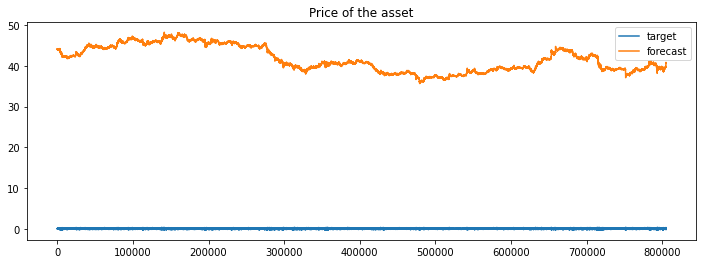

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(target, label='target')
plt.plot(pred, label='forecast')
plt.title('Price of the asset')
plt.legend()
plt.show()

Example of 1000 forecasts.

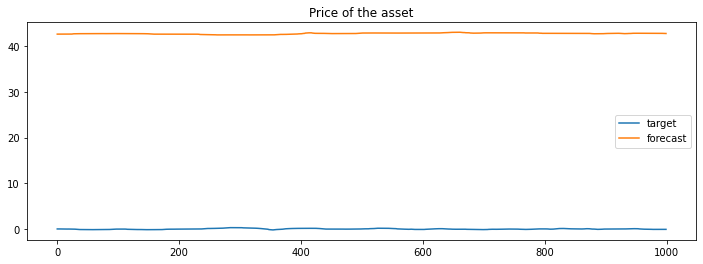

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(target[-100000:-99000], label='target')
plt.plot(pred[-100000:-99000], label='forecast')
plt.title('Price of the asset')
plt.legend()
plt.show()